#### Import potrzebnych bibliotek

In [51]:
# for loading data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# methods typing
from typing import List, Dict

import math

#### Funkcje pomocnicze

In [142]:
def data_stats(df: pd.DataFrame) -> pd.DataFrame:
    data_stats = df.select_dtypes(['float','int', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32'])
    data_stats = data_stats.describe()
    data_stats = data_stats.transpose()
    data_stats['std'] = round(data_stats['std'],2)
    data_stats['mean'] = round(data_stats['mean'],2)
    data_stats['dtype'] = df.dtypes
    return data_stats


def display_correlations(df: pd.DataFrame, x: int = 12, y: int = 12) -> plt.figure:
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(x, y))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

def remove_outliers(df: pd.DataFrame, columns: List[str], error_discriminator: float = 1.5) -> pd.DataFrame:
    for column in columns:
        q1 = df[column].describe()['25%']
        q3 = df[column].describe()['75%']
        iqr = q3 - q1
        df = df[df[column] > q1 - error_discriminator * iqr]
        df = df[df[column] < q3 + error_discriminator * iqr]
    return df

        
def histogram(df: pd.DataFrame, columns: List[str], height: int = 12, width: int = 12, 
               n_cols: int = 2, kde: bool = False, hist: bool = True, color: str = "b") -> plt.figure:
    if len(columns) == 1:
        plt.figure(figsize=(width, height))
        sns.distplot(df[columns[0]], kde=kde, hist=hist, color=color)
        plt.show()
        return
    f, axes = plt.subplots(math.ceil(len(columns) / n_cols), n_cols, figsize=(width, height), sharex=True)
    sns.despine(left=True)
    
    if len(columns) > n_cols:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[math.floor(i / n_cols), math.floor(i + 1 / n_cols) % n_cols])    
    else:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[i])

### Wczytanie danych

In [3]:
data_raw = pd.read_json("/Users/kamil/Desktop/ids-store-export.json")["bus-datav2-139"]
data_without_nans: List[Dict] = []
    
for record in data_raw:
    if type(record) == dict:
        data_without_nans.append(record)

df = pd.DataFrame(data=data_without_nans)

df["date"] = pd.to_datetime(df["date"])
df["time"] = pd.to_datetime(df["time"]).dt.time

currTravelTime: List[float] = []
for record in df["currTravelTime"]:
    try:
        if record[-1] == "'":
            record = record[:-1]
    except Exception as e:
        pass
    currTravelTime.append(float(record))
df["currTravelTime"] = pd.Series(currTravelTime)

df = df.astype({"currSpeed": "float16", "currTravelTime": "float16" , "delay": "int16" ,
                "routeId": "int64", "stop": "int16", "temp": "float32", "tripId": "int64",
                "weekday": "int8", "patternText": "int16"})

import requests

BASE_ROUTE_URL = "http://91.223.13.70/internetservice/services/routeInfo/routeStops?routeId="
ROUTE_ID_139 = "8095257447305839175"

data = requests.get("http://91.223.13.70/internetservice/services/routeInfo/routeStops?routeId=8095257447305839175").json()
STOPS_MAP: Dict[int,str] = {int(stop.get('number')):stop.get('name') for stop in data['stops']}

df['stopName'] = [ STOPS_MAP.get(stop) for stop in df.stop ]
df = df[sorted(df.columns)]

df.head()

,currSpeed,currTravelTime,date,delay,direction,patternText,routeId,stop,stopName,temp,time,tripId,weather,weekday
0,27.0,101.0,2020-07-20,-64,Kombinat,139,8095257447305839175,2878,Chopina,294.369995,21:18:00,8095261304186695939,Rain,0
1,30.0,102.0,2020-07-20,-187,Kombinat,139,8095257447305839175,3113,Dobrego Pasterza,294.369995,21:18:00,8095261304188842255,Rain,0
2,30.0,102.0,2020-07-20,-187,Mydlniki,139,8095257447305839175,3113,Dobrego Pasterza,294.369995,21:18:00,8095261304188940546,Rain,0
3,39.0,110.0,2020-07-20,-129,Kombinat,139,8095257447305839175,388,Dunikowskiego,294.369995,21:18:00,8095261304186544397,Rain,0
4,39.0,110.0,2020-07-20,-129,Mydlniki,139,8095257447305839175,388,Dunikowskiego,294.369995,21:18:00,8095261304188293392,Rain,0


In [4]:
df.shape

(31275, 14)

In [5]:
df.dtypes

currSpeed                float16
currTravelTime           float16
date              datetime64[ns]
delay                      int16
direction                 object
patternText                int16
routeId                    int64
stop                       int16
stopName                  object
temp                     float32
time                      object
tripId                     int64
weather                   object
weekday                     int8
dtype: object

#### Opis danych

| pole               | opis | typ danych | 
|--------------------|------|------------|
| `currSpeed`        | Przybliżona prędkość pojazdów w okolicy przystanku o id `stop` | `float16` |
| `currTravelTime` | Przybliżony czas pokonania określonego odcinka drogi w pobliżu przystanku o id `stop` | `float16` |
| `date` | Data (w formacie `datetime`) dokonania pomiaru | `datetime64` |
| `delay` | Czas podawany w sekundach mówiący ile za wcześnie/ za późno na przystanek przyjechał autobus | `int16` |
| `direction` | Kierunek trasy autobusu (A -> B lub B -> A) | `string` |
| `patternText` | Identyfikator linii autobusowej, np. `139` | `int16`|
| `routeId` | Identyfikator linii autobusowej z API | `int64` | 
| `stop` | Identyfikator przystanku autobusowego | `int16` |
| `stopName` | Nazwa przystanku autobusowego | `string` |
| `temp` | Temperatura powietrza w Krakowie, w chwilii dokonania pomiaru | `float32` |
| `time` | Czas dokonania pomiaru w postaci `GG:MM` | `datetime.time` |
| `tripId` | Identyfikator kursu autobusu na linii o danych `routeId` | `int64` |
| `weather` | Opis aktualnej pogody w Krakowie, w chwilii dokonania pomiaru, np. `Rain` | `string` |
| `weekday` | Dzień tygodnia (niedziela - `0`) | `int8` |

#### Statystyki danych

Zwrócić uwagę na max-min i wartości standardowe dla każdego atrybutu

In [6]:
data_stats(df)

,count,mean,std,min,25%,50%,75%,max,dtype
currSpeed,31275.0,inf,18.77,4.000000e+00,2.800000e+01,4.000000e+01,5.400000e+01,7.900000e+01,float16
currTravelTime,31275.0,inf,inf,7.000000e+00,3.200000e+01,5.600000e+01,9.100000e+01,7.720000e+02,float16
delay,31275.0,-8.269000e+01,78.19,-4.710000e+02,-1.400000e+02,-5.100000e+01,-2.000000e+01,2.900000e+01,int16
patternText,31275.0,1.390000e+02,0.00,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,int16
routeId,31275.0,8.095257e+18,0.00,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,int64
stop,31275.0,1.180810e+03,1231.38,5.000000e+00,1.080000e+02,4.170000e+02,2.533000e+03,3.459000e+03,int16
temp,31275.0,2.928600e+02,4.03,2.848900e+02,2.893200e+02,2.937700e+02,2.954500e+02,2.997600e+02,float32
tripId,31275.0,8.095261e+18,1851504.74,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,int64
weekday,31275.0,2.910000e+00,1.21,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,int8


Żeby lepiej dostrzec te zależności przydadzą się wykresy rozkładów.

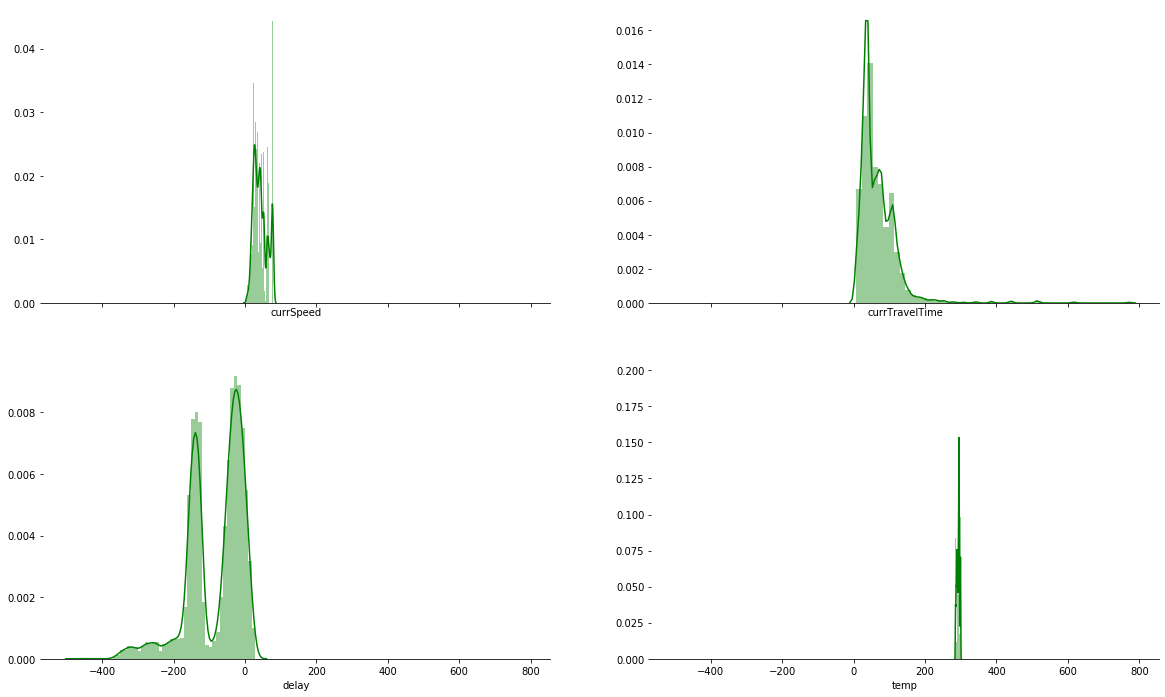

In [152]:
histograms(df, columns=['currSpeed', 'currTravelTime', 'delay', 'temp'], height=12, width=20, kde=True, color="g")

#### Histogram `delay` (przed i po czyszczeniu danych)

In [36]:
df.groupby(['stopName', 'weekday']).mean().loc["Aleja Róż"]

,currSpeed,currTravelTime,delay,patternText,routeId,stop,temp,tripId
weekday,,,,,,,,
0,52.00000,31.000000,-83.083333,139.0,8095257447305839616,416.0,293.726685,8095261304188122112
1,49.90625,33.250000,-77.068966,139.0,8095257447305839616,416.0,290.466766,8095261304188200960
2,45.28125,39.125000,-86.666667,139.0,8095257447305839616,416.0,292.701080,8095261304188163072
3,48.34375,34.125000,-75.596939,139.0,8095257447305839616,416.0,292.088379,8095261304188192768
4,45.90625,36.562500,-79.010256,139.0,8095257447305839616,416.0,294.224243,8095261304188181504
5,51.28125,31.609375,-108.201923,139.0,8095257447305839616,416.0,295.539124,8095261304188258304


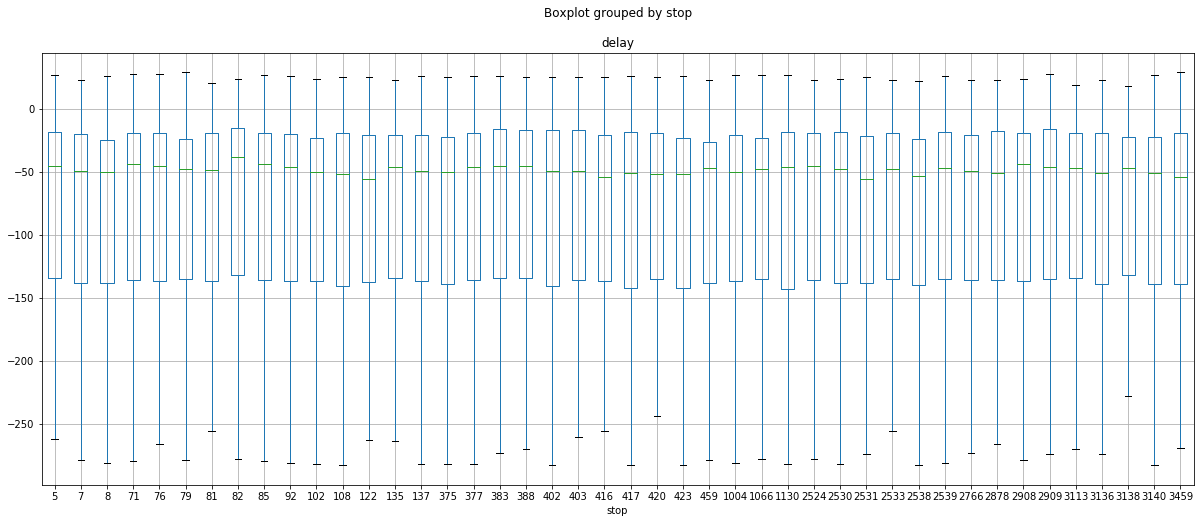

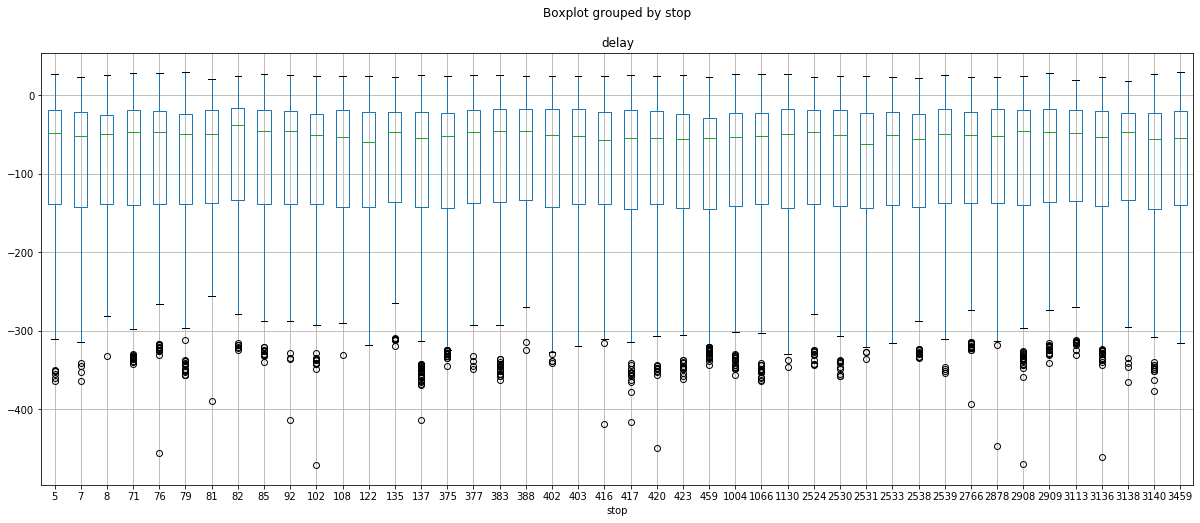

In [17]:
df_without_outliners.boxplot(by='stop', column=['delay'], figsize=(20,8))
df.boxplot(by='stop', column=['delay'], figsize=(20,8))